In [37]:
import numpy as np
import bilby
import gwpy
import sys
sys.path.insert(0,'..')
import pygwb.util
from pygwb.simulator import Simulator
from scipy import optimize

# Inject a power spectrum in randomised LIGO noise

### injection of a broken power law 

In [38]:
frequencies_x = np.linspace(0, 1000, 10000)

alpha1 = 6
alpha2 = 0
fref = 10
omegaRef = 5.e-5

def IntensityGW(freqs, omegaRef, alpha1, fref, alpha2 = 2/3):
    ''' GW Intensity function from broken power law in OmegaGW '''
    '''
    
    PARAMETERS
    freqs: np.array
        frequency array
    fref: 
        reference frequency
    omegaRef: 
        Value of OmegaGW at reference frequency
    alpha1:
        first spectral index
    alpha2:
        second spectral index
        
    RETURN
    FrequencySeries
    
    '''
    from pygwb.constants import H0
    H_theor = (3 * H0 ** 2) / (10 * np.pi ** 2)
    
    fknee = fref
    
    power = np.zeros_like(freqs)
    
    power[freqs<fknee] = H_theor * omegaRef * (freqs[freqs<fknee]) ** (alpha1 -3) * fref**(-alpha1)
    power[freqs>fknee] = H_theor * omegaRef * (freqs[freqs>fknee]) ** (alpha2 - 3) * fref**(-alpha2)
    power[freqs==fknee] = H_theor * omegaRef * (fknee) ** (alpha2 -3) * fref**(-alpha2)
    
    #power[freqs<10.]= omegaRef * (10. / fref) ** alpha1
    power[0] = power[1]
    
    return gwpy.frequencyseries.FrequencySeries(power, frequencies=freqs)

Intensity_GW_inject = IntensityGW(frequencies_x, omegaRef = omegaRef, alpha1 = alpha1, fref = fref)

### set up bilby interferometers and initialise Simulator

In [39]:
sampling_frequency = 1024
duration = 60

ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

ifo_list = [ifo_H1, ifo_L1]

for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))

simulator_1 = Simulator(ifo_list, Intensity_GW_inject, 60, duration = duration, sampling_frequency = sampling_frequency)
dataset = simulator_1.gen_data

### check out one minute of data

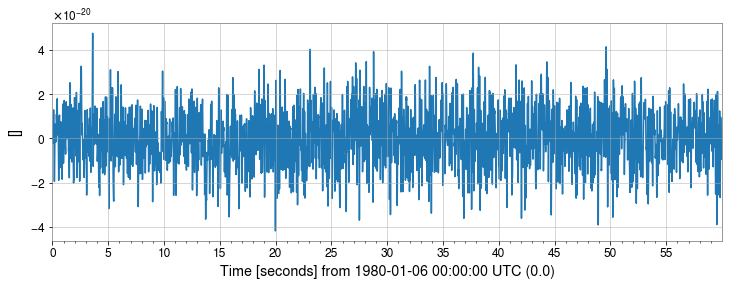

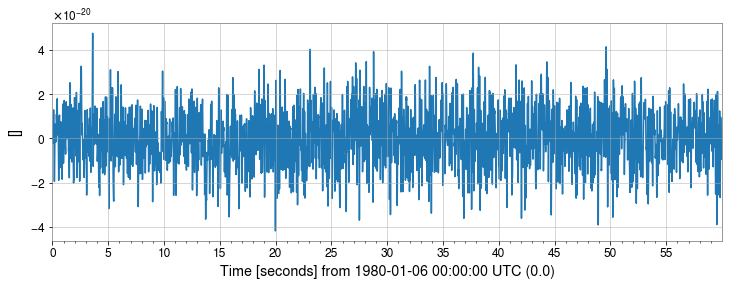

In [40]:
from gwpy.timeseries import TimeSeries

data_H1, data_L1 = dataset

crop_start_time = data_H1.t0.value
crop_duration   = 60
dt = data_H1.dt

data_H1_1min = data_H1.crop(start = crop_start_time, end = crop_start_time + crop_duration)
data_H1_1min.plot()

Text(0, 0.5, 'PSD')

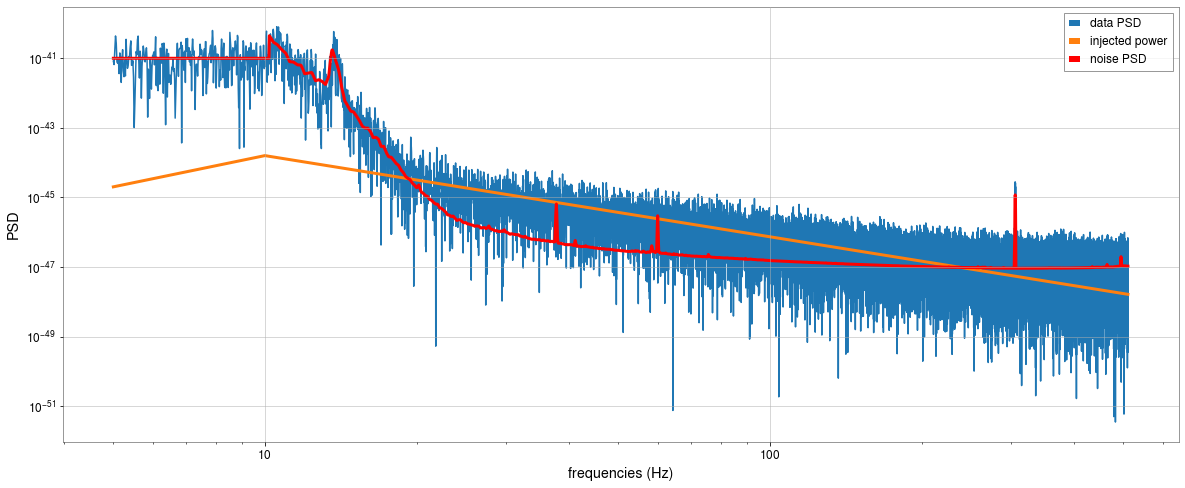

In [41]:
import matplotlib.pyplot as plt

frequencies = data_H1_1min.psd().frequencies.value

mask = frequencies>5.

ax, fig = plt.subplots(figsize = (20,8))
plt.loglog(frequencies[mask], data_H1_1min.psd().value[mask], label = 'data PSD')
plt.loglog(frequencies[mask], simulator_1.IntensityGW[mask], linewidth = 3, label = 'injected power')
plt.loglog(frequencies[mask], simulator_1.noise_PSD_array[0][mask], linewidth = 3, color = 'red', label = 'noise PSD')
plt.legend()
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')

### Simple injection recovery test

In [16]:
#Function to fit the data to (linear in logs)
def func(x,a,b):
    return np.exp(a*np.log10(x)+b)

In [17]:
Ntests=200

spectral_array=np.zeros(Ntests)
intercept_array=np.zeros(Ntests)
mask1=(frequencies>20)&(frequencies<200)

for ii in range(Ntests):
    simulator_1 = Simulator(ifo_list, Intensity_GW_inject, 60, duration = duration, sampling_frequency = sampling_frequency)
    dataset = simulator_1.gen_data
    data_H1, data_L1 = dataset

    crop_start_time = data_H1.t0.value
    crop_duration   = 60
    dt = data_H1.dt

    data_H1_1min = data_H1.crop(start = crop_start_time, end = crop_start_time + crop_duration)
    
    popt,pcov=optimize.curve_fit(func,frequencies[mask1],data_H1_1min.psd().value[mask1])
    
    spectral_array[ii]=popt[0]
    intercept_array[ii]=popt[1]

spectral_avg=np.sum(spectral_array)/Ntests
intercept_avg=np.sum(intercept_array)/Ntests

In [36]:
from pygwb.constants import H0
H_theor = (3 * H0 ** 2) / (10 * np.pi ** 2)

omegaRef_avg=func(fref,spectral_avg,intercept_avg)/H_theor*fref**3

print(f"% average recovered spectral index from fits: {np.abs(np.abs(spectral_avg))}")
print(f"% average recovered Omega(fref) from fits: {omegaRef_avg}")
print(f"% difference between spectral indices: {np.abs((spectral_avg+alpha1)/alpha1)}")
print(f"% difference between Omega(fref): {np.abs(omegaRef-omegaRef_avg)/omegaRef}")

% average recovered spectral index from fits: 6.259616560029411
% average recovered Omega(fref) from fits: 8.699730884754181e-05
% difference between spectral indices: 0.043269426671568446
% difference between Omega(fref): 0.7399461769508362


Text(0, 0.5, 'PSD')

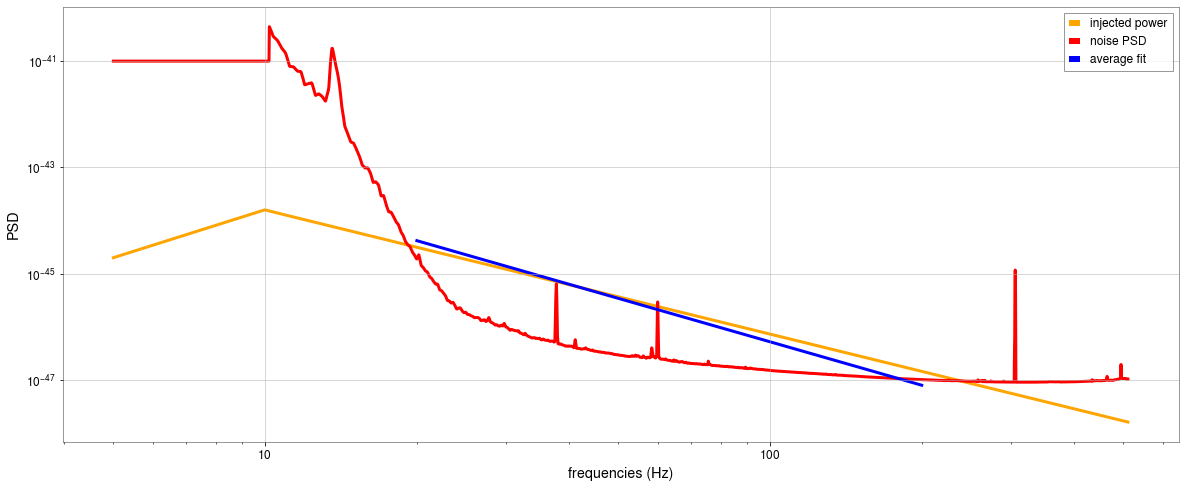

In [35]:
ax, fig = plt.subplots(figsize = (20,8))
plt.loglog(frequencies[mask], simulator_1.IntensityGW[mask], linewidth = 3, label = 'injected power',color='orange')
plt.loglog(frequencies[mask], simulator_1.noise_PSD_array[0][mask], linewidth = 3, color = 'red', label = 'noise PSD')
plt.loglog(frequencies[mask1], func(frequencies[mask1],spectral_avg,intercept_avg), linewidth = 3, color = 'blue', label = 'average fit')
plt.legend()
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')